# 🧠 `serket` mental model
1) **Single Sample Code**: Write code for a single data sample (un-batched) and use `jax`'s `vmap` to apply it to a batch of data. This approach is efficient and concise.

2) **Functional updates of stateful Object-Oriented Code**: `serket` lets you write stateful object-oriented code. You can update the state functionally using `.at['method_name'](...)`

3) **Transformation Transparent Code**: Write code that works under any `jax` transformation. This approach makes the code reusable, easier to understand, and less error-prone.


The following code showcases these principles

In [1]:
import jax
import functools as ft
import serket as sk
import matplotlib.pyplot as plt


class Linear(sk.TreeClass):
    def __init__(self, in_features: int, out_features: int, key: jax.random.KeyArray):
        self.weight = jax.random.normal(key, (in_features, out_features))
        self.bias = jax.numpy.zeros((out_features,))
        self.counter = 0.0

    def __call__(self, x: jax.Array):
        return x @ self.weight + self.bias


# to showcase the functional update of with stateful modules
# lets define a tree of modules with stateful updates in the call method


@sk.autoinit
class Linears(sk.TreeClass):
    def __init__(self):
        self.l1 = Linear(1, 120, key=jax.random.PRNGKey(0))
        self.l2 = Linear(120, 120, key=jax.random.PRNGKey(1))
        self.l3 = Linear(120, 1, key=jax.random.PRNGKey(2))

    def __call__(self, x: jax.Array) -> jax.Array:
        # stateful updates
        self.l1.counter += 1.0
        self.l2.counter += 1.0
        self.l3.counter += 1.0

        # forward pass for single sample
        x = self.l1(x)
        x = jax.numpy.tanh(x)
        x = self.l2(x)
        x = jax.numpy.tanh(x)
        x = self.l3(x)
        return x

l1 counter = 1000.0
l2 counter = 1000.0
l3 counter = 1000.0


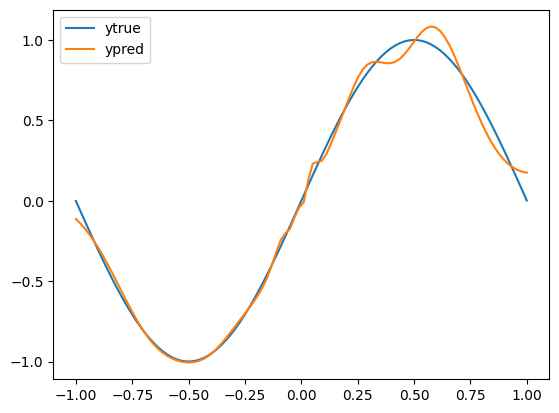

In [2]:
net = Linears()

x = jax.numpy.linspace(-1, 1, 100)[:, None]
y = jax.numpy.sin(x * 3.14)


@ft.partial(jax.grad, has_aux=True)
def loss_func(net: Linears, x: jax.Array, y: jax.Array):
    # apply net to (1) batched input
    # with functional (2) stateful updates
    # `.at[method_name]` return a tuple of the method output and
    # the updated state, since we only need to vectorize the output
    # but not the state we use `out_axes=(0, None)`
    ypred, net = jax.vmap(net.at["__call__"], out_axes=(0, None))(x)
    # here net state is updated
    return jax.numpy.mean((y - ypred) ** 2), net


@jax.jit
def train_step(net: Linears, x: jax.Array, y: jax.Array):
    net_grad, net = (loss_func)(net, x, y)
    net = jax.tree_map(lambda x, y: x - 1e-3 * y, net, net_grad)
    return net


for i in range(1_000):
    net = train_step(net, x, y)

ypred, _ = jax.vmap(net.at["__call__"], out_axes=(0, None))(x)

plt.plot(x, y, label="ytrue")
plt.plot(x, ypred, label="ypred")
plt.legend()

print(f"l1 counter = {net.l1.counter}")
print(f"l2 counter = {net.l2.counter}")
print(f"l3 counter = {net.l3.counter}")

**Optional** : `jaxpr` analysis

How is the state is updated under hood?, in essence the layer leaves are copied, Then the instance method is allowed to operate on this copied version and return the modified version as output.


```python
>>> jax.make_jaxpr(jax.vmap(net.at["__call__"], out_axes=(0, None)))(x)
{ lambda a:f32[1,120] b:f32[120] c:f32[] d:f32[120,120] e:f32[120] f:f32[] g:f32[120,1]
    h:f32[1] i:f32[]; j:f32[100,1]. let
    # Copying the leaves
    k:f32[1,120] = copy a
    l:f32[120] = copy b
    m:f32[] = copy c
    n:f32[120,120] = copy d
    o:f32[120] = copy e
    p:f32[] = copy f
    q:f32[120,1] = copy g
    r:f32[1] = copy h
    s:f32[] = copy i
    # Stateful updates
    t:f32[] = add m 1.0
    u:f32[] = add p 1.0
    v:f32[] = add s 1.0
    # Batched forward pass
    w:f32[100,120] = dot_general[dimension_numbers=(([1], [0]), ([], []))] j k
    x:f32[1,120] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 120)] l
    y:f32[100,120] = add w x
    z:f32[100,120] = tanh y
    ba:f32[100,120] = dot_general[dimension_numbers=(([1], [0]), ([], []))] z n
    bb:f32[1,120] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 120)] o
    bc:f32[100,120] = add ba bb
    bd:f32[100,120] = tanh bc
    be:f32[100,1] = dot_general[dimension_numbers=(([1], [0]), ([], []))] bd q
    bf:f32[1,1] = broadcast_in_dim[broadcast_dimensions=(1,) shape=(1, 1)] r
    bg:f32[100,1] = add be bf
  in (bg, k, l, t, n, o, u, q, r, v) }

```